In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [2]:
workdir = "./workdir/"
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imwrite(workdir + "chessboard.tiff", imboard)

True

In [24]:
datadir = workdir+"data/"
images = np.array([datadir + f for f in os.listdir(datadir) if f.endswith(".jpg") ])
order = np.argsort([int(p.split(".")[-2].split("_")[-1]) for p in images])
images = images[order]
images

array(['./workdir/data/WIN_20201012_11_31_01.jpg',
       './workdir/data/WIN_20201012_11_30_08.jpg',
       './workdir/data/WIN_20201012_11_32_19.jpg',
       './workdir/data/WIN_20201012_11_29_19.jpg',
       './workdir/data/WIN_20201012_11_29_21.jpg',
       './workdir/data/WIN_20201012_11_29_23.jpg',
       './workdir/data/WIN_20201012_11_31_25.jpg',
       './workdir/data/WIN_20201012_11_29_26.jpg',
       './workdir/data/WIN_20201012_11_29_29.jpg',
       './workdir/data/WIN_20201012_11_32_30.jpg',
       './workdir/data/WIN_20201012_11_29_39.jpg',
       './workdir/data/WIN_20201012_11_32_40.jpg',
       './workdir/data/WIN_20201012_11_29_44.jpg',
       './workdir/data/WIN_20201012_11_28_45.jpg',
       './workdir/data/WIN_20201012_11_32_46.jpg',
       './workdir/data/WIN_20201012_11_32_48.jpg',
       './workdir/data/WIN_20201012_11_28_51.jpg',
       './workdir/data/WIN_20201012_11_30_51.jpg',
       './workdir/data/WIN_20201012_11_30_52.jpg',
       './workdir/data/WIN_2020

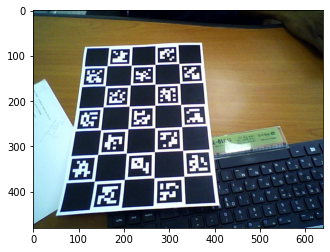

In [25]:
im = PIL.Image.open(images[0])
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

Now, the camera calibration can be done using all the images of the chessboard. Two functions are necessary:

The first will detect markers on all the images and.
The second will proceed the detected markers to estimage the camera calibration data.

In [5]:
def read_chessboards(images):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0
    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)
        
        if len(corners)>0:
            # SUB PIXEL DETECTION
            for corner in corners:
                cv2.cornerSubPix(gray, corner, 
                                 winSize = (3,3), 
                                 zeroZone = (-1,-1), 
                                 criteria = criteria)
            res2 = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)        
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])              
        
        decimator+=1   

    imsize = gray.shape
    return allCorners,allIds,imsize

In [26]:
allCorners,allIds,imsize=read_chessboards(images)

POSE ESTIMATION STARTS:
=> Processing image ./workdir/data/WIN_20201012_11_31_01.jpg
=> Processing image ./workdir/data/WIN_20201012_11_30_08.jpg
=> Processing image ./workdir/data/WIN_20201012_11_32_19.jpg
=> Processing image ./workdir/data/WIN_20201012_11_29_19.jpg
=> Processing image ./workdir/data/WIN_20201012_11_29_21.jpg
=> Processing image ./workdir/data/WIN_20201012_11_29_23.jpg
=> Processing image ./workdir/data/WIN_20201012_11_31_25.jpg
=> Processing image ./workdir/data/WIN_20201012_11_29_26.jpg
=> Processing image ./workdir/data/WIN_20201012_11_29_29.jpg
=> Processing image ./workdir/data/WIN_20201012_11_32_30.jpg
=> Processing image ./workdir/data/WIN_20201012_11_29_39.jpg
=> Processing image ./workdir/data/WIN_20201012_11_32_40.jpg
=> Processing image ./workdir/data/WIN_20201012_11_29_44.jpg
=> Processing image ./workdir/data/WIN_20201012_11_28_45.jpg
=> Processing image ./workdir/data/WIN_20201012_11_32_46.jpg
=> Processing image ./workdir/data/WIN_20201012_11_32_48.jpg


In [22]:
def calibrate_camera(allCorners,allIds,imsize):   
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")
    
    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
    #flags = (cv2.CALIB_RATIONAL_MODEL) 
    (ret, camera_matrix, distortion_coefficients0, 
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics, 
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [27]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
Wall time: 7.18 s


In [21]:
ret

1.346470103201181

In [22]:
mtx

array([[385.77692162,   0.        , 326.19913359],
       [  0.        , 385.77692162, 360.60913298],
       [  0.        ,   0.        ,   1.        ]])

In [23]:
dist

array([[ 0.13427063],
       [ 0.37994075],
       [ 0.00605051],
       [-0.00499978],
       [ 2.70067548],
       [ 0.03752342],
       [ 0.5456706 ],
       [ 2.52938507],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

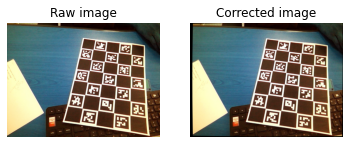

In [24]:
i=20 # select image id
plt.figure()
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame,mtx,dist,None)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.show()

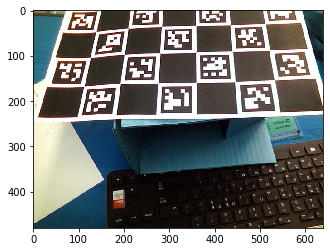

In [25]:
frame = cv2.imread(datadir+"WIN_20201012_11_31_25.jpg")
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

## Post processing

In [26]:

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
    
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

corners

[array([[[174.44167, 228.26782],
         [107.40477, 231.6322 ],
         [119.48623, 175.10106],
         [182.87738, 170.36757]]], dtype=float32),
 array([[[351.30334, 226.40816],
         [281.2541 , 226.6158 ],
         [284.43997, 168.37354],
         [351.20587, 167.66907]]], dtype=float32),
 array([[[533.91315, 221.56073],
         [461.54904, 223.86472],
         [456.01065, 165.49045],
         [524.63727, 162.43498]]], dtype=float32),
 array([[[105.7166  , 161.4423  ],
         [ 40.962597, 161.31702 ],
         [ 55.382725, 111.47884 ],
         [117.20071 , 111.59727 ]]], dtype=float32),
 array([[[267.49658, 153.46274],
         [202.2407 , 154.9443 ],
         [209.00775, 104.23762],
         [271.26608, 101.8767 ]]], dtype=float32),
 array([[[435.6853 , 150.53838],
         [369.35318, 151.80948],
         [368.3754 ,  99.78984],
         [432.05316,  98.41044]]], dtype=float32),
 array([[[611.67615, 143.04367],
         [541.51855, 146.46758],
         [532.4516 ,  95.4

Very fast processing !

## Results

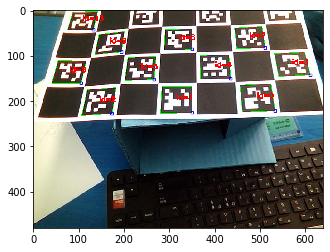

In [27]:
plt.figure()
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Add local axis on each marker

In [29]:
size_of_marker =  0.033 # side lenght of the marker in meter
rvecs,tvecs,_ = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)

In [59]:
length_of_axis = 0.01
imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

for i in range(len(tvecs)):
    imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

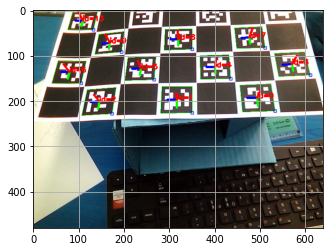

In [60]:
plt.figure()
plt.imshow(imaxis)
plt.grid()
plt.show()

In [32]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data

,tx,ty,tz
marker,,,
0,0.080762,-0.081032,0.186674
1,-0.004270,-0.079199,0.187257
2,-0.086577,-0.077579,0.189276
3,0.124055,-0.122908,0.196094
4,0.038740,-0.121084,0.198866
5,-0.044970,-0.119376,0.199828
6,-0.127405,-0.117819,0.204867
7,0.082422,-0.163361,0.210148
8,-0.002478,-0.161389,0.211203


In [33]:
datar = pd.DataFrame(data = tvecs.reshape(len(rvecs),3), columns = ["rx", "ry", "rz"], 
                    index = ids.flatten())
datar.index.name = "marker"
datar.sort_index(inplace= True)
np.degrees(datar)


,rx,ry,rz
marker,,,
0,4.627318,-4.642779,10.695656
1,-0.244650,-4.537790,10.729026
2,-4.960469,-4.444937,10.844719
3,7.107803,-7.042131,11.235353
4,2.219616,-6.937621,11.394192
5,-2.576613,-6.839713,11.449318
6,-7.299740,-6.750508,11.738031
7,4.722450,-9.359910,12.040610
8,-0.142008,-9.246888,12.101039


In [34]:
v = data.loc[3:6].values
((v[1:] - v[:-1])**2).sum(axis = 1)**.5

array([0.08537946, 0.08373296, 0.08260266])

In [35]:
cv2.Rodrigues(rvecs[0], np.zeros((3,3)))

(array([[-0.99279586, -0.02012166, -0.11811642],
        [ 0.01478781,  0.95768425, -0.28744078],
        [ 0.11890202, -0.28711671, -0.9504874 ]]),
 array([[ 1.62229129e-03, -6.52290558e-01,  9.74848708e-02,
         -6.52697567e-01, -1.74988517e-03, -3.94091888e-02,
          9.47214727e-02,  3.98769235e-02, -1.96484588e-04],
        [ 1.18511395e-01, -1.49531198e-01, -9.70642382e-01,
          1.48139839e-01, -2.51941714e-02, -7.63197074e-02,
          9.71110117e-01, -7.35563094e-02,  1.43701224e-01],
        [-1.74550568e-02, -1.74897056e-02,  1.49693240e-01,
          1.79574402e-02, -1.88496237e-01, -6.27100728e-01,
         -1.47977797e-01, -6.27507738e-01,  1.71041820e-01]]))

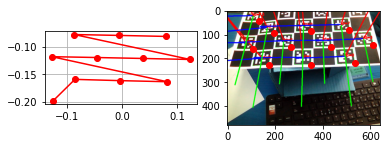

In [36]:
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1,2,1)
ax.set_aspect("equal")
plt.plot(data.tx, data.ty, "or-")
plt.grid()
ax = fig.add_subplot(1,2,2)
plt.imshow(imaxis, origin = "upper")
plt.plot(np.array(corners)[:, 0, 0,0], np.array(corners)[:, 0, 0,1], "or")
plt.show()

In [37]:
a = np.arange(50)
a

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [38]:
import pickle

In [39]:
f = open("truc.pckl", "wb")
pickle.dump(a, f)
f.close()

In [40]:
f = open("truc.pckl", "rb")
b = pickle.load(f)
b == a

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [41]:
corners = np.array(corners)
data2 = pd.DataFrame({"px": corners[:, 0, 0, 1], 
                      "py": corners[:, 0, 0, 0]}, index = ids.flatten())
data2.sort_index(inplace=True)
data2

,px,py
0,221.560730,533.913147
1,226.408157,351.303345
2,228.267822,174.441666
3,143.043671,611.676147
4,150.538376,435.685303
5,153.462738,267.496582
6,161.442307,105.716599
7,82.523254,512.052368
8,86.482292,350.901367
9,91.776085,194.551056


In [58]:
m0 = data2.loc[0]
m43 = data2.loc[9]
d01 = ((m0 - m43).values**2).sum()**.5
d = 42.5e-3 * (3.5**2 + 4.5**2)**.5
factor = d / d01
data2["x"] = data2.px * factor
data2["y"] = data2.py * factor
((data2[["x", "y"]].loc[11] - data2[["x", "y"]].loc[0]).values**2).sum()**.5


KeyError: 11

In [51]:

c = np.array(corners).astype(np.float64).reshape(11,4,2)
(((c[:, 1:] - c[:, :-1])**2).sum(axis = 2)**.5).mean(axis =1)

array([62.83220469, 65.04950421, 66.57726325, 59.4848731 , 59.5773376 ,
       60.68861028, 62.85215051, 53.56786329, 55.8109257 , 56.53541277,
       50.71196004])

In [44]:
help(cv2.aruco.detectMarkers)

Help on built-in function detectMarkers:

detectMarkers(...)
    detectMarkers(image, dictionary[, corners[, ids[, parameters[, rejectedImgPoints[, cameraMatrix[, distCoeff]]]]]]) -> corners, ids, rejectedImgPoints
    .   * @brief Basic marker detection
    .    *
    .    * @param image input image
    .    * @param dictionary indicates the type of markers that will be searched
    .    * @param corners vector of detected marker corners. For each marker, its four corners
    .    * are provided, (e.g std::vector<std::vector<cv::Point2f> > ). For N detected markers,
    .    * the dimensions of this array is Nx4. The order of the corners is clockwise.
    .    * @param ids vector of identifiers of the detected markers. The identifier is of type int
    .    * (e.g. std::vector<int>). For N detected markers, the size of ids is also N.
    .    * The identifiers have the same order than the markers in the imgPoints array.
    .    * @param parameters marker detection parameters
    .   

In [56]:
data2.loc[13]

px     42.728405
py    132.651550
Name: 13, dtype: float32

In [54]:
data2

,px,py
0,221.560730,533.913147
1,226.408157,351.303345
2,228.267822,174.441666
3,143.043671,611.676147
4,150.538376,435.685303
5,153.462738,267.496582
6,161.442307,105.716599
7,82.523254,512.052368
8,86.482292,350.901367
9,91.776085,194.551056


In [66]:
vid = cv2.VideoCapture(1)
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

frame_height = int(vid.get(4))
frame_width = int(vid.get(3))

videoOut = cv2.VideoWriter("outputPose2.avi", cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width, frame_height))

while vid.isOpened():

    ret, frame = vid.read()
    if ret == True:
        
        # detect ArUcO marker
        markerCorners, markerIds, rejectedCandidates = cv2.aruco.detectMarkers(frame,dictionary)
        img_clone =  frame.copy()
        # Display the detected markers
        img_clone = cv2.aruco.drawDetectedMarkers(img_clone, markerCorners, markerIds)
        #estinate pose
        size_of_marker =  0.033 # side lenght of the marker in meter
        rvecs,tvecs,_ = aruco.estimatePoseSingleMarkers(markerCorners, size_of_marker , mtx, dist)

        length_of_axis = 0.01
        imaxis = aruco.drawDetectedMarkers(frame.copy(), markerCorners, markerIds)
        if(tvecs is not None):
            for i in range(len(tvecs)):
                imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)

        cv2.imshow("image",np.hstack((frame,img_clone,imaxis)))#; cv2.waitKey(); cv2.destroyAllWindows()
        videoOut.write(imaxis)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
vid.release()
videoOut.release()

In [67]:
vid.release()
cv2.destroyAllWindows()

In [17]:
# grabing video

vid = cv2.VideoCapture("cam-calibrate.mp4")
cnt = 0
while(vid.isOpened()):
    ret, frame = vid.read()
    if ret == True:
        print("Processing Image ",cnt)
        cv2.imwrite(workdir+'data_CoppeliaSim/image_{0}_{0}.jpg'.format(cnt),frame)
        cnt+=1
    else:
        break

Processing Image  0
Processing Image  1
Processing Image  2
Processing Image  3
Processing Image  4
Processing Image  5
Processing Image  6
Processing Image  7
Processing Image  8
Processing Image  9
Processing Image  10
Processing Image  11
Processing Image  12
Processing Image  13
Processing Image  14
Processing Image  15
Processing Image  16
Processing Image  17
Processing Image  18
Processing Image  19
Processing Image  20
Processing Image  21
Processing Image  22
Processing Image  23
Processing Image  24
Processing Image  25
Processing Image  26
Processing Image  27
Processing Image  28
Processing Image  29
Processing Image  30
Processing Image  31
Processing Image  32
Processing Image  33
Processing Image  34
Processing Image  35
Processing Image  36
Processing Image  37
Processing Image  38
Processing Image  39
Processing Image  40
Processing Image  41
Processing Image  42
Processing Image  43
Processing Image  44
Processing Image  45
Processing Image  46
Processing Image  47
Pr